In [216]:
from __future__ import print_function
import pandas as pd
import os
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve


def download_file(file_url, folder_path, data_folder, file_name):
#     file_path = os.path.join(folder_path, data_folder, file_name)
    file_path = os.getcwd()+ data_folder+ file_name
    if not os.path.exists(file_path):
        print('Downloading file from ' + file_url + '...')
        urlretrieve(file_url, file_path)
        print('Done downloading file: '+file_path)
        input_file= pd.read_csv(url)
    else:
#         print('File: ' + file_path + ' already exists.')
        print(file_name + ' imported from local computer ')
        input_file= pd.read_csv(os.getcwd()+data_folder + file_name)
    return input_file


def download_dataset():
    print('Downloading Endava support tickets dataset...')
    folder_path =   os.getcwd() #os.path.join(         os.path.dirname(             os.path.abspath(__file__)        ),        'datasets'    )
    url = "https://privdatastorage.blob.core.windows.net/github/support-tickets-classification/datasets/all_tickets.csv"
    data_folder = "\Input_dataset\\"
    file_name = 'all_tickets.csv'
    input_data = download_file(url, folder_path, data_folder, file_name)
    return input_data


if __name__ == "__main__":
    emails_df= download_dataset()

all_tickets.csv imported from local computer 


<>:29: DeprecationWarning: invalid escape sequence \I
<>:29: DeprecationWarning: invalid escape sequence \I
<>:29: DeprecationWarning: invalid escape sequence \I
<ipython-input-216-49472b101d16>:29: DeprecationWarning: invalid escape sequence \I
  data_folder = "\Input_dataset\\"


In [158]:
import os, sys, email, re
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
import wordcloud

# Network analysis
import networkx as nx


# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# from sklearn.lda import LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation

import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from nltk.stem.porter import PorterStemmer





In [159]:
emails_df = emails_df[emails_df['title'].notna()]
emails_df.head()

,title,body,ticket_type,category,sub_category1,sub_category2,business_service,urgency,impact
1,connection with icon,icon dear please setup icon per icon engineers...,1,6,22,7,26,3,4
2,work experience user,work experience user hi work experience studen...,1,5,13,7,32,3,4
3,requesting for meeting,requesting meeting hi please help follow equip...,1,5,13,7,32,3,4
4,reset passwords for external accounts,re expire days hi ask help update passwords co...,1,4,2,76,4,3,4
5,mail,verification warning hi has got attached pleas...,1,4,3,7,89,3,4


# Topic Modelling on Title 

In [160]:
import spacy
from spacy.lang.en import English
# spacy.load('en')

parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [161]:
import nltk
import re

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mashv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [162]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [163]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
  
    
    tokens = [token.replace("\'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("[", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("]'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("\n'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("\r'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token.replace("'", "") for token in tokens if len(token) >= 3 ]
    tokens = [token for token in tokens if token not in en_stop]
    tokens= filter(lambda ThisWord: not re.match('^(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4}|am|pm)$', ThisWord), tokens)
    tokens = [get_lemma2(token) for token in tokens]
    return tokens

<>:12: DeprecationWarning: invalid escape sequence \/
<>:12: DeprecationWarning: invalid escape sequence \/
<>:12: DeprecationWarning: invalid escape sequence \/
<ipython-input-163-751d22501113>:12: DeprecationWarning: invalid escape sequence \/
  tokens= filter(lambda ThisWord: not re.match('^(?:(?:[0-9]{2}[:\/,]){2}[0-9]{2,4}|am|pm)$', ThisWord), tokens)


In [164]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mashv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [165]:
import random
text_data = []

for line in emails_df['title']:
    tokens = prepare_text_for_lda(line)
#     print(tokens)
    text_data.append(tokens)

In [166]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [167]:
import gensim
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=5, iterations=500)

In [168]:
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.108*"laptop" + 0.070*"update" + 0.039*"list" + 0.037*"request" + 0.037*"monitor" + 0.035*"license" + 0.031*"needed" + 0.031*"urgent" + 0.026*"system" + 0.023*"address"')
(1, '0.277*"error" + 0.068*"window" + 0.046*"upgrade" + 0.036*"open" + 0.032*"day" + 0.028*"ticket" + 0.028*"document" + 0.023*"cable" + 0.020*"logging" + 0.017*"help"')
(2, '0.118*"account" + 0.084*"request" + 0.053*"add" + 0.051*"server" + 0.050*"confluence" + 0.039*"mail" + 0.034*"team" + 0.029*"available" + 0.027*"wrong" + 0.025*"locked"')
(3, '0.427*"access" + 0.057*"network" + 0.046*"floor" + 0.025*"space" + 0.024*"file" + 0.022*"task" + 0.018*"via" + 0.017*"edit" + 0.017*"link" + 0.016*"disk"')
(4, '0.236*"issue" + 0.191*"oracle" + 0.069*"time" + 0.054*"working" + 0.036*"report" + 0.032*"missing" + 0.030*"notification" + 0.024*"log" + 0.018*"problem" + 0.016*"com"')
(5, '0.085*"problem" + 0.070*"change" + 0.050*"connection" + 0.045*"mailbox" + 0.039*"meeting" + 0.036*"room" + 0.029*"manager" + 0.027*"outl

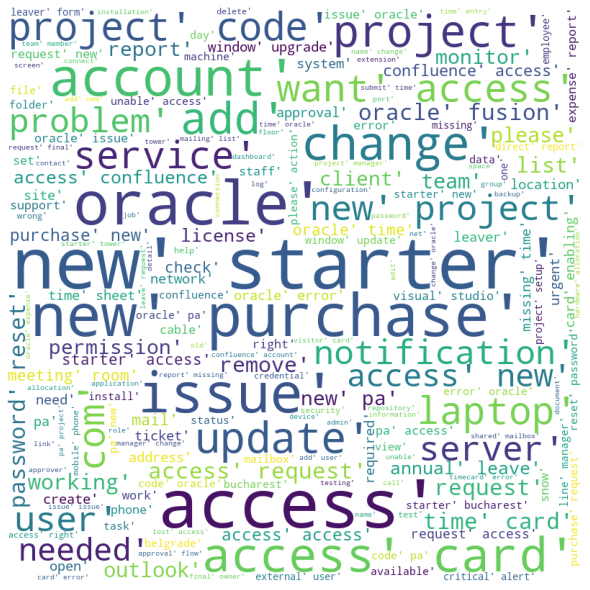

In [169]:
#Final word cloud after all the cleaning and pre-processing
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = en_stop 


for words in tokens: 
    comment_words += " ".join(words)+" "


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(str(text_data)) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [170]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [171]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.299673 -0.084756       1        1  13.086398
6     -0.111625  0.221657       2        1  12.506766
5      0.065576  0.204310       3        1  10.421422
2     -0.148323 -0.240698       4        1  10.311300
3     -0.073203  0.009791       5        1  10.271860
0     -0.121187 -0.241817       6        1   9.772949
9      0.257028 -0.093002       7        1   9.592434
1     -0.130238  0.049238       8        1   8.457207
8      0.077451  0.119181       9        1   8.226091
7     -0.115152  0.056095      10        1   7.353570, topic_info=          Term         Freq        Total Category  logprob  loglift
15      access  6106.000000  6106.000000  Default  30.0000  30.0000
32         new  4710.000000  4710.000000  Default  29.0000  29.0000
214      issue  4302.000000  4302.000000  Default  28.0000  28.0000
274      error  3259.000000  3259.000000  Default  27.0000  27.0000
58      oracle  3480.000000  3480.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1264       pop    78.474884    79.394417  Topic10  -4.8704   2.5983
183      audio    68.960381    69.879913  Topic10  -4.9996   2.5967
341       desk    68.786507    69.706032  Topic10  -5.0021   2.5967
3161     crash    68.483543    69.403160  Topic10  -5.0066   2.5966
8     external   210.567535   274.676971  Topic10  -3.8833   2.3442

[361 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1718      4  0.994585        able
447       9  0.994102     absence
15        5  0.999800      access
1207      6  0.986933  accessible
388       1  0.992986   accessing
...     ...       ...         ...
4         1  0.995146        work
904       1  0.999052     working
222       4  0.996889       wrong
3355     10  0.994754      yellow
1225      5  0.991336        zone

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 6, 3, 4, 1, 10, 2, 9, 8])

# Topic Modelling on message contents

In [172]:
#import os

In [173]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))
en_stop.add('thanks')
en_stop.add('please')
en_stop.add('hello')
en_stop.add('regards')
en_stop.add('regard')
en_stop.add('dear')
en_stop.add('thank')
en_stop.add('help')
en_stop.add('kind')
en_stop.add('name')
en_stop.add('also')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mashv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [174]:
import random
text_data = []

for line in emails_df['body']:
    tokens = prepare_text_for_lda(line)
#     print(tokens)
    text_data.append(tokens)

In [175]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

In [176]:
import gensim
NUM_TOPICS = 10
ldamodel_body = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=5, iterations=500)

In [177]:
topics = ldamodel_body.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.024*"issue" + 0.012*"know" + 0.011*"update" + 0.010*"access" + 0.010*"working" + 0.009*"work" + 0.009*"open" + 0.008*"best" + 0.008*"engineer" + 0.008*"check"')
(1, '0.059*"access" + 0.029*"code" + 0.025*"change" + 0.021*"analyst" + 0.016*"let" + 0.016*"tuesday" + 0.015*"best" + 0.015*"thursday" + 0.015*"request" + 0.015*"officer"')
(2, '0.069*"card" + 0.049*"approval" + 0.039*"july" + 0.036*"submit" + 0.024*"submitted" + 0.023*"expense" + 0.022*"error" + 0.021*"approve" + 0.021*"entry" + 0.019*"status"')
(3, '0.094*"report" + 0.071*"october" + 0.031*"action" + 0.021*"event" + 0.020*"date" + 0.020*"process" + 0.015*"absence" + 0.015*"direct" + 0.015*"november" + 0.014*"friday"')
(4, '0.049*"site" + 0.026*"confluence" + 0.025*"floor" + 0.024*"senior" + 0.024*"folder" + 0.023*"add" + 0.022*"engineer" + 0.020*"october" + 0.020*"tuesday" + 0.020*"user"')
(5, '0.061*"leave" + 0.042*"form" + 0.040*"annual" + 0.033*"request" + 0.026*"mailbox" + 0.025*"attached" + 0.023*"date" + 0.021*"

In [178]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel_body, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.000064 -0.135071       1        1  27.479290
1      0.102544 -0.172434       2        1  13.513872
9     -0.335881 -0.025495       3        1  10.173347
6      0.125610  0.117823       4        1   9.782936
4      0.154731 -0.085846       5        1   9.194825
5      0.093834 -0.173223       6        1   7.109660
2     -0.237332 -0.019038       7        1   6.126059
7      0.126023  0.162987       8        1   6.052546
3     -0.026477  0.007013       9        1   5.451232
8     -0.003117  0.323284      10        1   5.116237, topic_info=          Term          Freq         Total Category  logprob  loglift
9139      sent  18918.000000  18918.000000  Default  30.0000  30.0000
1064    access  14668.000000  14668.000000  Default  29.0000  29.0000
156     report   6820.000000   6820.000000  Default  28.0000  28.0000
415    october   8284.000000   8284.000000  Default  27.0000  27.0000
108       card   5619.000000   5619.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
336     number   1360.579956   5051.007812  Topic10  -3.9167   1.6611
35      client   1184.298096   5789.785156  Topic10  -4.0555   1.3858
192    provide    881.253174   3731.139160  Topic10  -4.3511   1.5296
396   calendar    558.354431    947.542419  Topic10  -4.8074   2.4439
74    received    631.563049   2443.217773  Topic10  -4.6842   1.6199

[633 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
9143      3  0.999666     able
157       6  0.006198  absence
157       9  0.993507  absence
1064      1  0.261789   access
1064      2  0.725714   access
...     ...       ...      ...
939       2  0.039147    write
939       5  0.960479    write
9202      3  0.998032      yes
213       1  0.191262     zone
213       5  0.808004     zone

[1315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 10, 7, 5, 6, 3, 8, 4, 9])

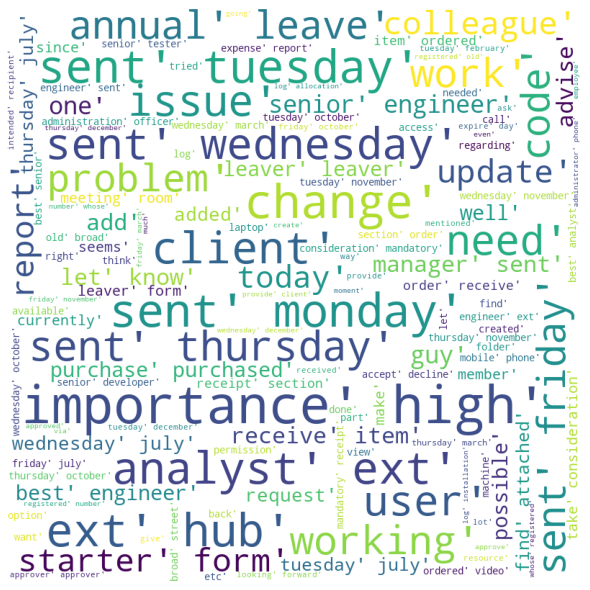

In [179]:
#Final word cloud after all the cleaning and pre-processing
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = en_stop 


for words in tokens: 
    comment_words += " ".join(words)+" "


wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(str(text_data)) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 